In [13]:
from typing import ClassVar, List, Dict, Optional
from pydantic import BaseModel, Field

from langchain_gigachat.chat_models import GigaChat
from datetime import datetime

from typing import  List, Dict
from pydantic import BaseModel
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END

import uuid
import json
import time

In [14]:
import phoenix as px
# session = px.launch_app(use_temp_dir=False) # Fo colab
session = px.launch_app()

Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [15]:
from phoenix.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor

tracer_provider = register(
  project_name="Agentic reasoning", # Default is 'default'
  endpoint="http://localhost:4317",
)

LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: Agentic reasoning
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [16]:
gigachat_api_key = ("key")


MAIN_TEMPLATE: ClassVar[str] = f"""Ты - AI архитектор предприятия. Сегодняшняя дата - {datetime.now().strftime('%Y-%m-%d')}
Твоя задача - анализировать данные из различных источников и выявлять взаимосвязи между системами."""

# Инициализация моделей
chat = GigaChat(
    credentials=gigachat_api_key,
    model="GigaChat-2-Max",
    verify_ssl_certs=False
)



In [17]:

class SystemRelation(BaseModel):
    system_a: str
    system_b: str
    relation_type: str
    description: str
    sources: List[str]

class SystemRelationsState(BaseModel):
    confluence_data: Dict = {}
    meta_data: Dict = {}
    telegram_data: List[str] = []
    aggregated_relations: List[SystemRelation] = []
    data_requests: List[str] = []
    search_results: Dict = {}
    file_data: Dict = {}
    analysis: Dict = {}
    

class Route(BaseModel):
    """Определяет следующий источник данных для обработки в workflow"""
    step: str = Field(..., description="Source to process next: confluence, meta, telegram, aggregate")

gigachat_router = chat.with_structured_output(Route)

In [18]:
#print(dir(chat))

In [19]:
gigachat_router = chat.with_structured_output(Route)

# Функции для работы с источниками данных

def get_confluence_data(state: SystemRelationsState):
    """Пример получения данных из Confluence"""
    print("Получение данных из Confluence...")
    # Здесь должен быть реальный код интеграции с Confluence API
    state.confluence_data = {
  "systems": {
    "UFS (A)": {
      "load_tps": 4500,
      "criticality": "critical",
      "aggregated_outgoing": [
        {
          "target_system": "KM (B)",
          "total_traffic_share": "92%",
          "protocols": ["HTTP", "Kafka"]
        }
      ],
      "subsystems": {
        "Потребительские кредиты": {
          "load_tps": 2500,
          "criticality": "critical",
          "outgoing": [
            {
              "target": "KM (B):Оркестратор",
              "type": "cascade",
              "protocol": "HTTP",
              "subsystem_traffic_share": "80%",
              "description": "Передача заявок на скоринг"
            }
          ]
        },
        "Образовательные кредиты": {
          "load_tps": 1200,
          "criticality": "high",
          "outgoing": [
            {
              "target": "KM (B):Оркестратор",
              "type": "cascade",
              "protocol": "HTTP",
              "subsystem_traffic_share": "95%",
              "description": "Проверка льготных программ"
            }
          ]
        },
        "Рефинансирование": {
          "load_tps": 800,
          "criticality": "medium",
          "outgoing": [
            {
              "target": "KM (B):ПДН",
              "type": "indirect",
              "protocol": "Kafka",
              "subsystem_traffic_share": "100%",
              "description": "Асинхронная передача истории платежей"
            }
          ]
        }
      }
    },
    "KM (B)": {
      "load_tps": 3800,
      "criticality": "critical",
      "aggregated_incoming": [
        {
          "source_system": "UFS (A)",
          "total_traffic_share": "89%",
          "protocols": ["HTTP", "Kafka"]
        }
      ],
      "aggregated_outgoing": [
        {
          "target_system": "ID System (C)",
          "total_traffic_share": "63%",
          "protocols": ["gRPC"]
        }
      ],
      "subsystems": {
        "Оркестратор": {
          "load_tps": 2000,
          "criticality": "critical",
          "outgoing": [
            {
              "target": "ID System (C):Валидация",
              "type": "cascade",
              "protocol": "gRPC",
              "subsystem_traffic_share": "100%",
              "description": "Проверка цифрового профиля"
            }
          ],
          "incoming": [
            {
              "source": "UFS (A):Потребительские кредиты",
              "system_traffic_impact": "32%"
            },
            {
              "source": "UFS (A):Образовательные кредиты",
              "system_traffic_impact": "28%"
            }
          ]
        },
        "Кредитный потенциал": {
          "load_tps": 900,
          "criticality": "high",
          "outgoing": [
            {
              "target": "ID System (C):История",
              "type": "indirect",
              "protocol": "gRPC",
              "subsystem_traffic_share": "40%",
              "description": "Запрос кредитной истории"
            }
          ]
        },
        "ПДН": {
          "load_tps": 600,
          "criticality": "medium",
          "incoming": [
            {
              "source": "UFS (A):Рефинансирование",
              "system_traffic_impact": "21%"
            }
          ]
        },
        "Антифрод": {
          "load_tps": 300,
          "criticality": "high",
          "outgoing": [
            {
              "target": "ID System (C):Биометрия",
              "type": "temporary",
              "protocol": "HTTP",
              "subsystem_traffic_share": "70%",
              "description": "Верификация по фото"
            }
          ]
        }
      }
    },
    "ID System (C)": {
      "load_tps": 2900,
      "criticality": "high",
      "subsystems": {
        "Валидация": {
          "load_tps": 1800,
          "criticality": "critical",
          "incoming": [
            {
              "source": "KM (B):Оркестратор",
              "system_traffic_impact": "62%"
            }
          ]
        },
        "История": {
          "load_tps": 700,
          "criticality": "medium",
          "incoming": [
            {
              "source": "KM (B):Кредитный потенциал",
              "system_traffic_impact": "24%"
            }
          ]
        },
        "Биометрия": {
          "load_tps": 400,
          "criticality": "high",
          "incoming": [
            {
              "source": "KM (B):Антифрод",
              "system_traffic_impact": "14%"
            }
          ]
        }
      }
    }
  },
  "metadata": {
    "dependency_analysis": {
      "critical_path": "UFS.Потребительские кредиты → KM.Оркестратор → ID System.Валидация",
      "bottleneck": "ID System.Валидация (1800 TPS)",
      "fraud_flow": "UFS → KM.Антифрод → ID System.Биометрия"
    },
    "protocol_usage": {
      "HTTP": "Синхронные запросы между фронт-системами",
      "gRPC": "Высоконагруженные внутренние коммуникации",
      "Kafka": "Асинхронная передача массовых данных"
    }
  }
}
    return {"confluence_data": state.confluence_data}


def get_meta_data(state: SystemRelationsState):
    """Пример получения данных из Meta системы"""
    print("Получение данных из Meta...")
    # Здесь должен быть реальный код интеграции с Meta API
    state.meta_data = {
        "systems": [
            {"name": "Система A", "dependencies": ["Система B"]},
            {"name": "Система B", "dependencies": ["Система C"]}
        ]
    }
    return {"meta_data": state.meta_data}


def get_telegram_data(state: SystemRelationsState):
    """Пример получения данных из Telegram"""
    print("Получение данных из Telegram...")
    # Здесь должен быть реальный код интеграции с Telegram API
    state.telegram_data = [
        "В чате DevOps: Система E временно использует ресурсы Системы F до миграции"
    ]
    return {"telegram_data": state.telegram_data}


In [20]:
from langchain.chains import LLMChain
def analyze_relations(state: SystemRelationsState):
    """Анализ и агрегация данных."""
    
    # Формирование шаблона для запроса
    prompt = ChatPromptTemplate.from_template("""
    Анализируй входящие данные и агрегируй их. У нас есть три источника данных:
    1. Confluence Data: {confluence}
    2. Meta Data: {meta}
    3. Telegram Data: {telegram}
    
    Обработай данные, выяви важные связи, и выведи отчет о взаимосвязях и возможных паттернах. Ты анализируешь только техническую часть автоматизированной системы. Ты НЕ ОЦЕНИВАЕШЬ БИЗНЕС данные.Если между системами нет необходимо акцентировать внимание на том, что между системами связи не выявлено
    """)
    
    # Инициализация модели (используется OpenAI, но можно заменить на любую другую модель)
      # Можете заменить на нужную модель
    
    # Создание цепочки для обработки данных
    chain = LLMChain(prompt=prompt, llm=chat, output_parser=StrOutputParser())
    
    # Входные данные в формате JSON
    inputs = {
        "confluence": json.dumps(state.confluence_data, ensure_ascii=False),
        "meta": json.dumps(state.meta_data, ensure_ascii=False),
        "file_data": json.dumps(state.file_data, ensure_ascii=False),
        "telegram": "\n".join(state.telegram_data)
    }
    
    # Выполняем анализ данных
    analysis_result = chain.run(inputs)
    
    # Сохраняем результат анализа в состояние
    state.analysis = analysis_result
    
    # Возвращаем обновленное состояние с результатами анализа
    return state

In [21]:
# Function to read client data from a JSON file
def read_client_data_from_file(file_path: str) -> Dict:
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            file_data = json.load(file)
        return file_data
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return {}

# Function to read client data and update the state
def read_client_data(state: SystemRelationsState, file_path="file2.json"):
    file_data = read_client_data_from_file(file_path)
    state.file_data = file_data
    return {"file_data": state.file_data}

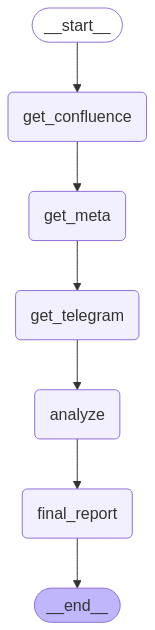

In [22]:


class SystemRelation(BaseModel):
    system_a: str
    system_b: str
    relation_type: str
    description: str
    sources: List[str]

class SystemRelationsState(BaseModel):
    confluence_data: Dict = {}
    meta_data: Dict = {}
    telegram_data: List[str] = []
    aggregated_relations: List[SystemRelation] = []
    data_requests: List[str] = []
    search_results: Dict = {}
    analysis: str = ""  # Добавлено новое поле
    report: str = ""    # Добавлено поле для отчета


# Функции обработки данных




# Исправленная функция format_final_report
def format_final_report(state: SystemRelationsState):
    """Формирование итогового отчета"""
    prompt = ChatPromptTemplate.from_template("сформировать агрегированные данные из источников в формате json, НЕ ПРИДУМЫВАЙ когда собираешь источники данных бери данные только из функций confluence meta telegram")  # Ваш шаблон промпта
    
    chain = prompt | chat | StrOutputParser()
    state.report = chain.invoke({"analysis": state.analysis})
    return state  # Возвращаем обновленное состояние
# Маршрутизация
def router(state: SystemRelationsState):
    """Определение следующего шага обработки"""
    if not state.confluence_data:
        return {"decision": "confluence"}
    if not state.meta_data:
        return {"decision": "meta"}
    if not state.telegram_data:
        return {"decision": "telegram"}
    return {"decision": "aggregate"}

# Построение графа
workflow = StateGraph(SystemRelationsState)

workflow.add_node("get_confluence", get_confluence_data)
workflow.add_node("get_meta", get_meta_data)
workflow.add_node("get_telegram", get_telegram_data)
workflow.add_node("analyze", analyze_relations)
workflow.add_node("final_report", format_final_report)

workflow.add_edge("get_confluence", "get_meta")
workflow.add_edge("get_meta", "get_telegram")
workflow.add_edge("get_telegram", "analyze")
workflow.add_edge("analyze", "final_report")
workflow.add_edge("final_report", END)

workflow.set_entry_point("get_confluence")
app = workflow.compile()

app

In [23]:
# Запуск
async def run_agent():
    inputs = {"user_query": "Построй карту взаимосвязей между системами"}
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    async for event in app.astream_events(inputs, version="v2"):
        event_type = event.get('event', None)
        node = event.get('name', '')
        
        if event_type == 'on_chain_start':
            print(f"\n[{node.upper()}]")
        elif event_type == 'on_chain_end':
            print(f"[/{node.upper()}]")
        elif event_type == 'on_chat_model_stream':
            print(event['data']['chunk'].content, end='')

start = time.time()
await run_agent()
print(f"\nTotal time: {time.time() - start:.2f}s")

Transient error StatusCode.UNAVAILABLE encountered while exporting traces to localhost:4317, retrying in 1s.



[LANGGRAPH]

[__START__]

[_WRITE]
[/_WRITE]

[_WRITE]
[/_WRITE]
[/__START__]

[GET_CONFLUENCE]
Получение данных из Confluence...

[_WRITE]
[/_WRITE]
[/GET_CONFLUENCE]

[GET_META]
Получение данных из Meta...

[_WRITE]
[/_WRITE]
[/GET_META]

[GET_TELEGRAM]
Получение данных из Telegram...

[_WRITE]
[/_WRITE]
[/GET_TELEGRAM]

[ANALYZE]

[LLMCHAIN]
### Отчет о взаимосвязях и паттернах

#### **Источник данных: Confluence**

**1. UFS (A)**  
   - Нагрузка: 4500 TPS  
   - Критичность: критическая  
   - Основные подсистемы: Потребительские кредиты, Образовательные кредиты, Рефинансирование  
   - Связь с системой **KM (B)**: 
      - Основной трафик идет через HTTP и Kafka  
      - Подсистема **«Потребительские кредиты»** передает заявки на скоринг в систему **KM (B): Оркестратор**.  
      - Подсистема **«Образовательные кредиты»** проверяет льготы через тот же интерфейс.  
      - Подсистема **«Рефинансирование»** асинхронно отправляет историю платежей в систему **KM (B): ПДН** через Kaf